# Exercise 9
FIRSTNAME LASTNAME
## Task 2 - Rectification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import h5py

In [2]:
# load data
with h5py.File('task2.mat', 'r') as file:
    data = {key: np.array(file[key]).T for key in file.keys()}

F = data["F"]
points_l = data["points_l"]
points_r = data["points_r"]
Ml = data["Ml"]
Mr = data["Mr"]

In [3]:
F.shape

(3, 3)

In [4]:
imgl = cv.imread("books1.jpg", cv.IMREAD_GRAYSCALE)
imgr = cv.imread("books2.jpg", cv.IMREAD_GRAYSCALE)

In [5]:
# TODO compute epipoles once more
def compute_epipole(F):
    U, S, Vt = np.linalg.svd(F)
    e = Vt[-1]
    return e / e[-1]  # Normalize

er = compute_epipole(F.T)  
el = compute_epipole(F)  
print('The right epipole is :\n', er)
print('The left epipole is :\n', el)


The right epipole is :
 [2.49157698e+03 3.42753341e+02 1.00000000e+00]
The left epipole is :
 [ 1.25122052e+03 -1.71033992e+02  1.00000000e+00]


In [6]:
def deshear(img, H):
    # this is already fully implemented and used, you do not need to do anything with this function
    h, w = img.shape
    hh, hw = np.array(img.shape) // 2
    a = H @ np.array([hw, 1, 1])
    a /= a[-1]
    b = H @ np.array([w, hh, 1])
    b /= b[-1]
    c = H @ np.array([hw, h, 1])
    c /= c[-1]
    d = H @ np.array([1, hh, 1])
    d /= d[-1]
    x = b - d
    y = c - a
    k1 = (h**2 * x[1] ** 2 + w**2 * y[1] ** 2) / (h * w * (x[1] * y[0] - x[0] * y[1]))
    k2 = (h**2 * x[0] * x[1] + w**2 * y[0] * y[1]) / (h * w * (x[0] * y[1] - x[1] * y[0]))

    Hn = np.eye(3)
    Hn[0, :2] = [-k1, -k2]
    return Hn


In [7]:
center = np.array(imgl.shape) // 2


def rectify_right(er, center):
    ex, ey, ez = er
    G = np.array([[1, 0, 0], [0, 1, 0], [-1/ex, 0, 1]])  
    T = np.array([[1, 0, -center[1]], [0, 1, -center[0]], [0, 0, 1]])
    
    norm_factor = np.sqrt(ex**2 + ey**2)
    R = np.array([[ex / norm_factor, ey / norm_factor, 0],
                  [-ey / norm_factor, ex / norm_factor, 0],
                  [0, 0, 1]])
    Hr = G @ R @ T
    return Hr


Hr = rectify_right(er, center)
Hrf = deshear(imgr, Hr) @ Hr


In [8]:
print('The right projective transformation matrix is :\n', Hr)
print('The right desheared projective transformation is :\n', Hrf)


The right projective transformation matrix is :
 [[ 9.90670172e-01  1.36281365e-01 -1.67244893e+02]
 [-1.36281365e-01  9.90670172e-01 -9.30760210e+01]
 [-3.97607691e-04 -5.46968308e-05  1.06712411e+00]]
The right desheared projective transformation is :
 [[ 9.85657651e-01  1.36974418e-01 -1.66557679e+02]
 [-1.36281365e-01  9.90670172e-01 -9.30760210e+01]
 [-3.97607691e-04 -5.46968308e-05  1.06712411e+00]]


In [9]:
Hr.shape

(3, 3)

In [10]:
def rectify_left(pl, pr, Mr, Hr):    
    # Compute the transformation M = Mr * Ml^-1
    Ml_inv = np.linalg.inv(Ml[:, :3])  # Ensure we invert only the 3x3 submatrix
    M = Mr[:, :3] @ Ml_inv  

    # Compute the skew-symmetric matrix of e_r
    er_cross = np.array([
        [0, -er[2], er[1]],
        [er[2], 0, -er[0]],
        [-er[1], er[0], 0]
    ])
    
    # Check if F ≈ [e_r]_x M
    F_check = er_cross @ M
    assert np.allclose(F, F_check, atol=1e-5), "F does not satisfy [e_r]_x M"

    # Apply Hr to right points
    pr_transformed = Hr @ pr  # (3, N)
    # Convert to inhomogeneous coordinates
    pr_transformed /= pr_transformed[-1]  
    
    # Compute H_l using least squares: solve for H_l that maps pl_h to pr_h_transformed
    H, _, _, _ = np.linalg.lstsq(pl.T, pr_transformed.T, rcond=None)
    H = H.T  # Transpose back

    return H

Hl = rectify_left(points_l, points_r, Mr, Hrf)
Hlf = deshear(imgl, Hl) @ Hl


In [11]:
print('The left projective transformation matrix is :\n', Hl)
print('The left desheared projective transformation is :\n', Hlf)

The left projective transformation matrix is :
 [[ 8.60899583e-01 -4.06467000e-01 -1.04588486e+02]
 [ 2.28885645e-01  1.03684054e+00 -1.66167610e+02]
 [ 5.94423101e-17 -7.28583860e-17  1.00000000e+00]]
The left desheared projective transformation is :
 [[ 1.03571724e+00 -2.29133887e-01 -1.57231894e+02]
 [ 2.28885645e-01  1.03684054e+00 -1.66167610e+02]
 [ 5.94423101e-17 -7.28583860e-17  1.00000000e+00]]


## Helper functions

In [12]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from skimage import img_as_float


def interpolate_transform_image(I, H):
    # Create meshgrid over the image
    xl, yl = np.meshgrid(
        np.arange(I.shape[1]), 
        np.arange(I.shape[0]), 
        indexing="xy"
    )
    # Turn the 2D grid into 1D arrays
    p1 = np.vstack((xl.ravel(), yl.ravel(), np.ones(xl.size)))

    # Transform the points and normalize
    p2 = H @ p1
    p2 /= p2[2]

    # Interpolate the image to the points
    I = img_as_float(I)
    cL = I.ravel()
    F = LinearNDInterpolator(p2[:2].T, cL)

    return F, p2


def warp_images(Fl, pl2, Fr, pr2):
    # Find min and max values
    minL = np.min(pl2[:2, :], axis=1)
    maxL = np.max(pl2[:2, :], axis=1)
    minR = np.min(pr2[:2, :], axis=1)
    maxR = np.max(pr2[:2, :], axis=1)

    minLR = np.minimum(minL, minR)
    maxLR = np.maximum(maxL, maxR)

    # Create meshgrid over the min and max values
    X, Y = np.meshgrid(
        np.arange(np.floor(minLR[0]), np.ceil(maxLR[0])+1),
        np.arange(np.floor(minLR[1]), np.ceil(maxLR[1])+1),
        indexing='xy'
    )
    Il1 = Fl(X, Y)
    Ir1 = Fr(X, Y)

    return Il1, Ir1, minLR


## Visualize the results

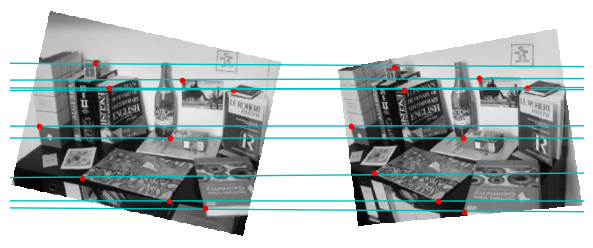

In [13]:
# interpolate and show stuff
Fr, pr2 = interpolate_transform_image(imgr, Hrf)
Fl, pl2 = interpolate_transform_image(imgl, Hlf)

wil, wir, minlr = warp_images(Fl, pl2, Fr, pr2)

pln = Hlf @ points_l
pln = pln[:2] / pln[2] - minlr[:, None]
prn = Hrf @ points_r
prn = prn[:2] / prn[2] - minlr[:, None]

h, w = wil.shape
for ptl, ptr in zip(pln.T, prn.T):
    plt.plot([0, w*2], [ptl[1], ptr[1]], "-c", lw=1, ms=0)
    plt.plot([ptl[0], ptr[0] + w], [ptl[1], ptr[1]], "or", lw=1, ms=3)


plt.imshow(np.concatenate([wil, wir], axis=1), cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

## Questions and answers:

### What is the purpose of rectification? Are the features from both images aligned vertically after the rectification?

### The goal of rectification is:

* #####  Align Matching Points: In the original images, matching points may not be horizontally positioned due to variations in perspective. Rectification adjusts the images so that these matching points line up along a single row in both images.

### The advantage of rectification is:

* ##### Facilitate Depth Calculation: After rectification, it becomes simpler to identify correspondences between the two images (i.e., matching pixels that depict the same physical point). This streamlines the stereo matching process, enhancing the accuracy and efficiency of depth estimation.

##### After rectification, the corresponding points should be aligned horizontally, not vertically, as the process is aimed at simplifying the stereo matching along the horizontal axis.